# Largest users

In [39]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path
from pandas import DataFrame as DF
from slurm_analyzer import SLURMAnalyzer
import pandas as pd
from datetime import datetime
import tabulate
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(("science", "notebook"))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# dpath = Path("..", 'data')
# assert dpath.is_dir()
dpath = Path.home() / "tmp"


In [41]:
df = pd.concat([
    SLURMAnalyzer().parse(json.loads((dpath / "sacct_pli_core.json").read_text())),
    SLURMAnalyzer().parse(json.loads((dpath / "sacct_pli_campus.json").read_text())),
    SLURMAnalyzer().parse(json.loads((dpath / "sacct_pli_large_campus.json").read_text()))
])

Filtered 29421 jobs (16%) with no gpus
Filtered 53984 jobs (36%) with < 10min run time
Filtered 7580 jobs (14%) with no gpus
Filtered 18639 jobs (41%) with < 10min run time
Filtered 199 jobs (11%) with no gpus
Filtered 620 jobs (39%) with < 10min run time


In [42]:
df.partition.unique()

array(['pli-c', 'pli', 'pli-lc'], dtype=object)

In [55]:
def get_monthly_compute_by_user(df: DF, partition: str | None = None, thld: float | None = None, add_other: bool = True) -> DF:
    """Compute GPU time by user, aggregated monthly, with optional partition filtering and thresholding."""
    if partition is not None:
        df = df[df["partition"] == partition]
    cbu = df.groupby("user")["gpu_time_h"].sum().div(3)
    if thld is not None:
        below = cbu[cbu < thld]
        cbu = cbu[cbu >= thld]
        if add_other:
            cbu.loc["Σ other"] = below.sum()
    return cbu.sort_values(ascending=False)

In [49]:
cbu = get_monthly_compute_by_user(df)

In [50]:
def plot_cumulative_gpu_usage(cbu: pd.Series) -> None:
    """Plot cumulative GPU usage percentage for users sorted by usage."""
    total = cbu.sum()
    cbu_sorted = cbu.sort_values(ascending=False)
    cumulative_pct = cbu_sorted.cumsum() / total * 100
    user_rank = range(1, len(cbu_sorted) + 1)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(user_rank, cumulative_pct.values)
    ax.set_xlabel("Top N Users")
    ax.set_ylabel("Cumulative GPU Usage (%)")
    ax.set_title("Cumulative GPU Usage by Top Users")
    ax.set_xlim(0, 50)
    ax.grid(True)
    fig.tight_layout()
    plt.show()

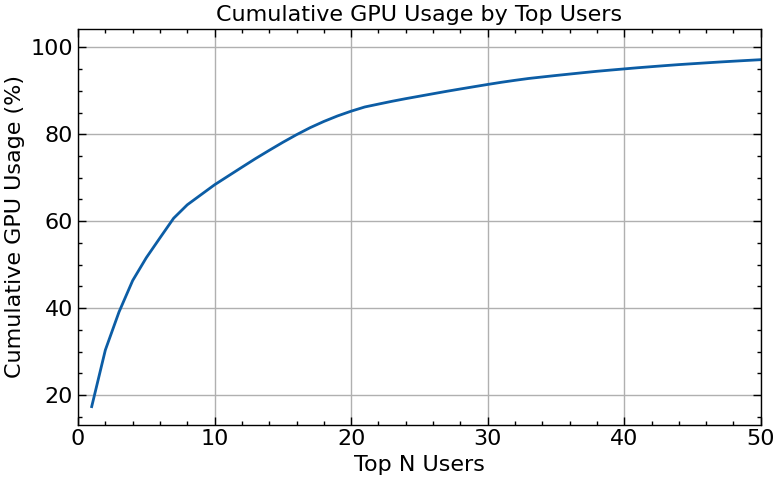

In [51]:
plot_cumulative_gpu_usage(cbu)

In [58]:
users_10k = get_monthly_compute_by_user(df, thld=10_000, add_other=False).index.tolist()

In [64]:
user_data = data = {
    "tianyug": {"pi": "Danqi Chen", "name": "Tianyu Gao"},
    "awettig": {"pi": "Danqi Chen", "name": "Alexander Wettig"},
    "jg9945": {"pi": "Danqi Chen", "name": "Jiayi Geng"},
    "jtuyls": {"pi": "Karthik Narasimhan", "name": "Jens Tuyls"},
    "ap34": {"pi": "Sanjeev Arora", "name": "Abhishek Panigrahi"},
    "ab4197": {"pi": "Danqi Chen", "name": "Adithya Bhaskar"},
    "hyen": {"pi": "Danqi Chen", "name": "Howard Yen"},
    "hc22": {"pi": "Danqi Chen", "name": "Howard Chen"},
    "haoyu": {"pi": "Sanjeev Arora", "name": "Haoyu Zhao"},
    "hw5449": {"pi": "Martin C. Jonikas", "name": "Haoyu Wu"},
    "eh7657": {"pi": "Michael A. Skinnider", "name": "Ehud Herbst"},
    "wg0420": {"pi": "Tri Dao", "name": "Wentao Guo"},
    "juhyunp": {"pi": "Sanjeev Arora", "name": "Juhyun Park"},
    "ke7953": {"pi": "Sanjeev Arora", "name": "Kawin Ethayarajh"},
    "yl7690": {"pi": "Chi Jin", "name": "Yong Lin"},
    "ym0081": {"pi": "Danqi Chen", "name": "Yu Meng"},
    "tianlec": {"pi": "Kai Li", "name": "Tianle Cai"}
}

In [74]:

def add_names(cbu: pd.Series, user_data: dict[str, dict[str, str]]) -> pd.DataFrame:
    """Combine GPU usage with user metadata."""
    df = cbu.rename("gpu_time_h").to_frame()
    df["user"] = df.index
    df["name"] = df["user"].map(lambda u: user_data.get(u, {}).get("name", ""))
    df["pi"] = df["user"].map(lambda u: user_data.get(u, {}).get("pi", ""))
    df["gpu_time_1k_h"] = (df["gpu_time_h"] / 1_000).astype("int")
    df["email"] = df["user"].map(lambda u: f"{u}@princeton.edu")
    return df[["gpu_time_1k_h", "user", "name", "pi", "email"]]


add_names(get_monthly_compute_by_user(df, thld=10_000, add_other=False), user_data)

,gpu_time_1k_h,user,name,pi,email
user,,,,,
tianyug,102,tianyug,Tianyu Gao,Danqi Chen,tianyug@princeton.edu
awettig,77,awettig,Alexander Wettig,Danqi Chen,awettig@princeton.edu
jg9945,51,jg9945,Jiayi Geng,Danqi Chen,jg9945@princeton.edu
jtuyls,42,jtuyls,Jens Tuyls,Karthik Narasimhan,jtuyls@princeton.edu
ap34,31,ap34,Abhishek Panigrahi,Sanjeev Arora,ap34@princeton.edu
ab4197,26,ab4197,Adithya Bhaskar,Danqi Chen,ab4197@princeton.edu
hyen,26,hyen,Howard Yen,Danqi Chen,hyen@princeton.edu
hc22,18,hc22,Howard Chen,Danqi Chen,hc22@princeton.edu
haoyu,13,haoyu,Haoyu Zhao,Sanjeev Arora,haoyu@princeton.edu


Text(0.5, 1.0, 'Users with >10k GPU hours')

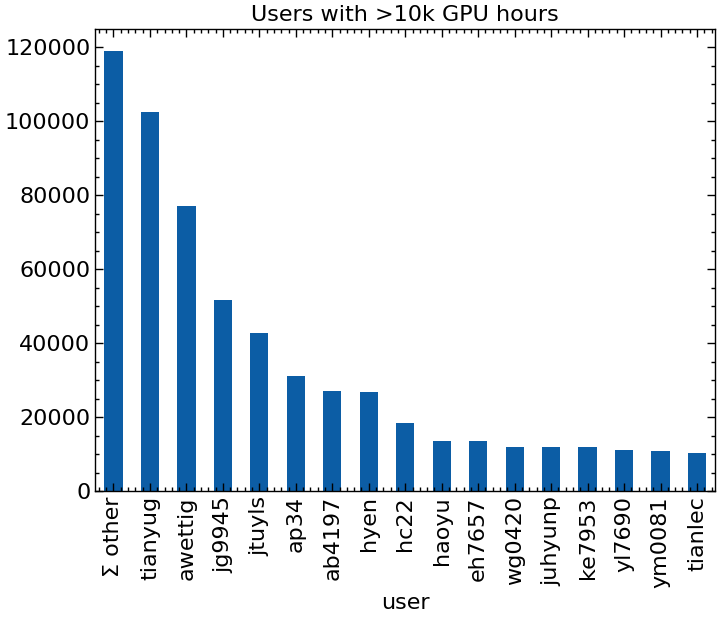

In [52]:
ax = get_monthly_compute_by_user(df, thld=10_000).plot.bar()
ax.set_title("Users with >10k GPU hours")

In [63]:
df[df.n_gpus > 32]["gpu_time_h"].sum() / df["gpu_time_h"].sum()

np.float64(0.02018288553663211)